In [1]:
%pylab inline
from analysis_toolbox import *
from qualityBaseline import *
import pandas as pd 

Populating the interactive namespace from numpy and matplotlib


In [2]:
bb_info = pd.read_csv('../../crowd-seg/analysis/computed_my_COCO_BBvals.csv')
obj_sorted_tbl =  bb_info[bb_info['Jaccard [COCO]']!=-1][bb_info['Jaccard [COCO]']!=0][bb_info['Jaccard [Self]']!=0].sort('object_id')
object_id_lst  = list(set(obj_sorted_tbl.object_id))

for objid in object_id_lst:

    # Ji_tbl (bb_info) is the set of all workers that annotated object i 
    bb_objects  = obj_sorted_tbl[obj_sorted_tbl["object_id"]==objid]

In [3]:
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]

In [4]:
polygon_lst = []
for xyloc in xylocs:
    polygon_lst.append(Polygon(xyloc))

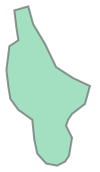

In [5]:
Polygon(xyloc)

In [6]:
from shapely.geometry import MultiPolygon

In [7]:
Ji_polygons = MultiPolygon(polygon_lst)
Ji_polygons_buffered = Ji_polygons.buffer(0.001)

In [8]:
img_info,object_tbl,bb_info,hit_info = load_info()

In [52]:
# T = total number of tasks
# n = number of points in bounding box
# m = number of metric functions of interest
# W = total number of workers 
#metric functions of interest 
metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',"NME [COCO]","Num Points",\
               'Precision [Self]','Recall [Self]','Jaccard [Self]',"NME [Self]","Area Ratio"]
# metrics_lst = ['Precision [COCO]']
worker_lst = unique(bb_info.worker_id)
#Parameters: Priors
beta = 1
gamma = 1
theta = 1
# Hidden variables 
m = len(metrics_lst)
T = len(img_info)
W = len(worker_lst)
z = np.ones((50,T))# n x T
D = np.zeros((m,T))# m x T
b = np.zeros((m,W))# m x W
c = np.zeros((m,W))# m x W

In [53]:
def abslogN(param):
    '''
    Drawing from normal distribution with prior (std) as param, with mean centered at 0
    log without nan; nan if value <0
    '''
    return log(abs(random.normal(0,param)))

In [61]:
def compute_phii(metric):
    '''
    phi value compared to ground truth 
    '''
    if metric in ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',"NME [COCO]",\
       'Precision [Self]','Recall [Self]','Jaccard [Self]',"NME [Self]"]:
        return 1
    elif metric in ["Num Points","Area Ratio"]:
        return 0

In [68]:
def Q(beta,gamma,theta):
    w1=0.5
    w2=0.5
    loglikelihood=[]
    # Loop through all metrics 
    for k in range(m):
        #Loop through all task
        logpD_lst =[]
        for j in range(W):
            logpD_lst.append(abslogN(theta))
        logpD =sum(logpD_lst)
        #Loop through all workers
        worker_quality_prob=[]
        for i in range(T):
            worker_quality_prob.append(abslogN(beta)+ abslogN(gamma))
            logphiij_lst = []
            # Ji is the list of workers that annotated object i
            Ji = list(obj_sorted_tbl[obj_sorted_tbl["object_id"]==i].worker_id)
            for j in Ji : 
                j = int(np.where(worker_lst==j)[0])
                phii=compute_phii(metrics_lst[k])
                mu = phii-b[k][j]
                sig = sqrt(w1*D[k][i]**2+w2*c[k][j]**2)
                if sig==0: sig=1e-5
                logphiij_lst.append(log(abs(random.normal(mu,sig))))
        logphiij = sum(logphiij_lst)
        loglikelihood.append(sum(worker_quality_prob)+logphiij+logpD)
    return loglikelihood

In [70]:
Q(beta,gamma,theta)

[-154.97509350668449,
 -98.394975540288428,
 -139.32461870090896,
 -120.69006673540238,
 -672.04269576762817,
 -147.11081637527056,
 -153.13556397127766,
 -135.38650743772632,
 -144.0030059962391,
 -650.64347679946468]